In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest

In [2]:
standard_pfits = pd.read_pickle('./gridsearch-results/standard-participant_fits.pd.pkl')
obmdp_pfits = pd.read_pickle('./gridsearch-results/obmdp-participant_fits.pd.pkl')
main_df = pd.read_pickle('../data/exp1-main.pd.pkl')
obmdp_pfits = main_df[['cond', 'participant']].merge(
        obmdp_pfits, on='participant')

In [3]:
exp1_trials = pd.read_pickle('../data/exp1-demon_trajs.pd.pkl')
exp1_trials['traj_len'] = exp1_trials['traj'].apply(lambda t: len(t))

In [4]:
sns.set_palette(sns.color_palette([
    '#0072b2', '#009e73','#d55e00',  '#cc79a7', '#f0e442', '#56b4e9'
]))

# Modeling Parameters

In [13]:
#parameter space
do_discount = [.8, .85, .9, .95, .99, .9999]
do_randchoose = [0.0, .025, .05, .075, .1, .125, .15, .175, .2]
do_temp = [.1, .2, .4, .6, .8, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]

true_mdp_code = ['ooo', 'xoo', 'oxo', 'oox', 'xxo', 'xox', 'oxx', 'xxx']
show_discount = [.8, .85, .9, .95, .99]
show_reward = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]

show_randchoose = [.01, .02, .03, .04, .05, .06, .07, .08, .09,
                   .1, .2, .3]
show_temp = [0.01, .05, .1, .15, .2, .25,
             .3, .35, .4, .45, .5, .75, 1.0,
             2.0, 3.0, 4.0, 5.0, 6.0]

# Condition-wise tests

In [14]:
pfits_comparison = \
    obmdp_pfits[['cond', 'participant', 'loglikelihood']].\
    merge(
        standard_pfits, on='participant', 
        suffixes=('_obmdp', '_standard')
    )
    
cond_steps = exp1_trials.groupby(['cond', 'participant'])\
    ['traj_len'].sum().reset_index()
cond_steps = cond_steps.rename(columns={'traj_len': 'n_steps'})

pfits_comparison = pfits_comparison.merge(cond_steps,
                                          on=['cond', 'participant'])

## Log-likelihood ratio test

In [15]:
def calc_chi2_pval(LLR_test_stat, df):
    return scipy.stats.chi2.sf(x=LLR_test_stat, df=df)

In [16]:
pfits_comparison['obmdp_df'] = 7
pfits_comparison['standard_df'] = 4
pfits_comparison['df_diff'] = \
    pfits_comparison['obmdp_df'] - pfits_comparison['standard_df']

    
cond_loglike = pfits_comparison.groupby('cond')\
    [['loglikelihood_obmdp', 'loglikelihood_standard', 
      'n_steps', 'obmdp_df', 'standard_df', 'df_diff']].sum()

cond_loglike['LLR_test_stat'] = \
    2*(cond_loglike['loglikelihood_obmdp'] 
       - cond_loglike['loglikelihood_standard'])

cond_loglike['p_value'] = cond_loglike.apply(
    lambda r: calc_chi2_pval(r['LLR_test_stat'], r['df_diff']), 
    axis=1)
cond_loglike[['loglikelihood_obmdp', 
              'loglikelihood_standard',
              'df_diff',
              'LLR_test_stat',
              'p_value']]

,loglikelihood_obmdp,loglikelihood_standard,df_diff,LLR_test_stat,p_value
cond,,,,,
do,-513.674552,-564.065104,87,100.781104,1.482178e-01
show,-1453.912332,-1649.711768,87,391.598873,3.233852e-40


### Bootstrap technique

In [17]:
pfits_comparison['LLR_test_stat'] = \
    2*(pfits_comparison['loglikelihood_obmdp'] - 
       pfits_comparison['loglikelihood_standard'])

# randomly re-label the samples
# and calculate the new difference in means
def gen_reordered_sample(pooled, size1, size2):
    np.random.shuffle(pooled)
    new1 = pooled[:size1]
    new2 = pooled[-size2:]
    return new1.mean() - new2.mean()

pooled = pfits_comparison['LLR_test_stat'].copy()
counts = tuple(pfits_comparison.groupby('cond')['participant'].count())

np.random.seed(1234)
n_samples = 10000
estimates = [gen_reordered_sample(pooled, *counts) for _ in range(n_samples)]
estimates = np.array(estimates)

pfits_comparison.groupby('cond')['LLR_test_stat'].aggregate(['mean', 'std'])

,mean,std
cond,,
do,3.475210,4.629877
show,13.503409,8.781122


In [18]:
# This takes a minute
mean_LLR_test_stats = pfits_comparison.groupby('cond')['LLR_test_stat'].mean()
mean_diff = mean_LLR_test_stats['do'] - mean_LLR_test_stats['show']
print(mean_LLR_test_stats)
print(mean_diff)
print(((estimates < mean_diff).sum() + 1)/(len(estimates) + 1))

cond
do       3.475210
show    13.503409
Name: LLR_test_stat, dtype: float64
-10.028198928993472
9.999000099990002e-05


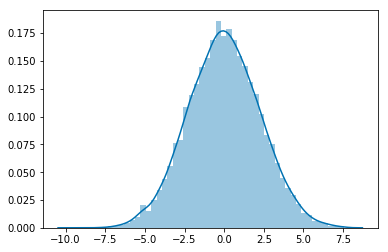

In [19]:
ax = sns.distplot(estimates)


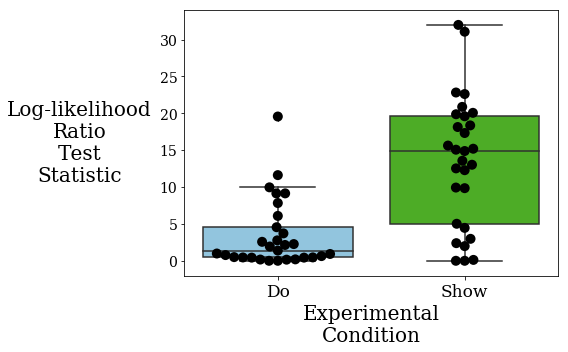

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.swarmplot(
    ax=ax,
    data=pfits_comparison,
    y='LLR_test_stat',
    x='cond',
    color="black",
    edgecolor="white",
    size=10,
    order=["do", "show"]
)
sns.boxplot(
    ax=ax,
    data=pfits_comparison,
    y='LLR_test_stat',
    x='cond',
    order=["do", "show"]
)
ax.set_ylabel("Log-likelihood\nRatio\nTest\nStatistic", 
              fontsize=20,
              family='serif',
              rotation=0, 
              labelpad=80,
              va='center')
plt.setp(ax.get_yticklabels(), 
         fontsize=14, family='serif')
_ = ax.set_xticklabels(["Do", "Show"],
                       fontsize=17, family='serif')
_ = ax.set_xlabel("Experimental\nCondition",
                  fontsize=20, family='serif')
plt.tight_layout()

colors = ["#92C5DE", "#4DAC26"]
for color, box in zip(colors, ax.artists):
    box.set_facecolor(color)
    
plt.savefig('./_figures/condition_teststats.eps')

In [207]:
pfits_comparison.groupby('cond')['LLR_test_stat'].mean()

cond
do       3.475210
show    13.503409
Name: LLR_test_stat, dtype: float64

# Parameter Analysis

In [35]:
param_fits = obmdp_pfits.groupby('cond').agg(['median', 'mean', 'sem'])
param_fits_dict = []
for cond, row in param_fits.iterrows():
    row_dict = {}
    for (param, est), val in row.iteritems():
        row_dict[param] = row_dict.get(param, {})
        row_dict[param][est] = val
    param_fits_row = {}
    for param, estvals in row_dict.items():
        if param in ['loglikelihood', 'n_bins']:
            continue
        param_fits_row[param] = "{mean:.2f} ({sem:.2f})".format(**estvals)
    param_fits_dict.append(param_fits_row)
param_fits_pd = pd.DataFrame(param_fits_dict, 
                             index=param_fits.index)

param_fits_pd[["do_discount", 
               "do_randchoose", 
               "do_temp", 
               "show_reward", 
               "show_discount", 
               "show_randchoose", 
               "show_temp"]].T

cond,do,show
do_discount,0.96 (0.01),0.93 (0.01)
do_randchoose,0.12 (0.02),0.09 (0.01)
do_temp,2.20 (0.25),1.64 (0.25)
show_reward,2.55 (0.74),5.31 (1.35)
show_discount,0.93 (0.01),0.93 (0.01)
show_randchoose,0.04 (0.01),0.05 (0.01)
show_temp,0.15 (0.03),0.22 (0.04)


In [ ]:
# for_latex = pd.DataFrame(param_fits_dict, index=param_fits.index)
# print(
#     for_latex[["do_discount", 
#                "do_randchoose", 
#                "do_temp", 
#                "show_reward", 
#                "show_discount", 
#                "show_randchoose", 
#                "show_temp"]].T.to_latex())

## Individual parameters

In [6]:
obmdp_pfits.groupby('cond')[['do_discount', 'do_randchoose', 'do_temp', 'show_discount', 'show_randchoose', 'show_reward', 'show_temp']].agg(['mean', 'sem'])

do_discount           do_randchoose             do_temp            \
            mean       sem          mean       sem      mean       sem   
cond                                                                     
do      0.955138  0.011620      0.116379  0.015708  2.203448  0.250688   
show    0.934114  0.012999      0.094828  0.013094  1.637931  0.251616   

     show_discount           show_randchoose           show_reward            \
              mean       sem            mean       sem        mean       sem   
cond                                                                           
do        0.934483  0.007064        0.035862  0.011771    2.551724  0.735427   
show      0.931034  0.008601        0.052069  0.011179    5.310345  1.346500   

     show_temp            
          mean       sem  
cond                      
do    0.148276  0.027192  
show  0.217586  0.042838

In [8]:
obmdp_pfits[obmdp_pfits['cond'] == 'show']\
    [['do_discount', 'do_randchoose', 'do_temp', 'show_discount', 'show_randchoose', 'show_reward', 'show_temp']].\
    corr()

,do_discount,do_randchoose,do_temp,show_discount,show_randchoose,show_reward,show_temp
do_discount,1.000000,0.275674,0.141517,0.036047,-0.080796,0.164892,-0.099574
do_randchoose,0.275674,1.000000,0.178742,0.206728,0.019437,0.296616,0.049701
do_temp,0.141517,0.178742,1.000000,0.339082,-0.240488,0.501110,-0.104010
show_discount,0.036047,0.206728,0.339082,1.000000,-0.287702,-0.189209,-0.300243
show_randchoose,-0.080796,0.019437,-0.240488,-0.287702,1.000000,-0.059612,-0.326737
show_reward,0.164892,0.296616,0.501110,-0.189209,-0.059612,1.000000,0.126644
show_temp,-0.099574,0.049701,-0.104010,-0.300243,-0.326737,0.126644,1.000000


In [14]:
from scipy.stats import pearsonr
showfits = obmdp_pfits[obmdp_pfits['cond'] == 'show']
pearsonr(showfits['show_reward'], showfits['do_temp'])

(0.5011099033165425, 0.005621793916559361)